# Topic Trends - Pandemics

This code was created from Martha and Sean's emerging topic code. 

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

#from brokenaxes import brokenaxes

ModuleNotFoundError: No module named 'brokenaxes'

### Data Ingestion

In [3]:
# pandemic corpus
#df = pd.read_pickle("../../../data/prd/Paper/case_studies/pandemic_corpus.pkl")
#df.reset_index(inplace=True, drop = True)

df = pd.read_csv('/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/doc2vec_final.csv')
df.reset_index(inplace=True, drop = True)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (19,20,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.shape

(582530, 37)

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,768,NaN,NaN,768,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,NaN,Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",1.0,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1.0,1.0,1999467.0,1.0,project explore game base metaphor enhanced ga...
1,771,NaN,NaN,771,89999,In partnership with the American Chemical Soci...,NaN,NaN,NaN,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",4.0,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1.0,1.0,51000.0,1.0,partnership american chemical society acs nati...
2,776,NaN,NaN,776,90006,MAPPING / CHARACTERIZATION / AND ANALYSIS OF C...,NaN,NaN,NaN,Data; Image; instrument; Maps; Radar; Titan,MAPPING / CHARACTERIZATION / AND ANALYSIS OF C...,NASA,NASA,NaN,NNX08BA81G,9/9/2008,9/8/2011,"BURR, DEVON",NaN,2.0,003387891,UNIVERSITY OF TENNESSEE KNOXVILLE,KNOXVILLE,TN,37996-0003,UNITED STATES,NaN,NaN,43.AAA,2008,197533.0,NaN,1.0,1.0,197533.0,1.0,mapping characterization analysis channel vall...
3,778,NaN,NaN,778,89993,Amphibian populations around the world are exp...,NaN,NaN,NaN,Amphibia; Central America; Communicable Diseas...,COLLABORATIVE RESEARCH: EVOLUTION OF AMPHIBIAN...,NSF,NSF,NaN,0815288,10/1/2008,3/31/2009,"LIPS, KAREN R",NaN,12.0,939007555,SOUTHERN ILLINOIS UNIVERSITY CARBONDALE,CARBONDALE,IL,62901-4709,UNITED STATES,NaN,NaN,47.074,2008,NaN,NaN,2.0,2.0,370996.0,2.0,amphibian population world experience decline ...
4,780,NaN,NaN,780,90011,The Ohio State University College of Education...,NaN,NaN,NaN,career; career development; Collaborations; Co...,MATH AND SCIENCE MIDDLE SCHOOL PATHWAYS PORTAL...,NSF,NSF,NaN,0840824,9/1/2008,8/31/2011,"LIGHTLE, KIMBERLY S","KAHLE, JANE; HENTON, MARY; NAIR-PILLAI, SARITA",15.0,071650709,OHIO STATE UNIVERSITY RESEARCH FOUNDATION,COLUMBUS,OH,43210-1016,UNITED STATES,NaN,NaN,47.076,2008,2369022.0,NaN,1.0,1.0,2369022.0,1.0,ohio state university college education osu na...


In [6]:
# input needed for NMF (from Scikit-Learn) is one string per document (not a list of strings)

text = df["final_tokens"]

In [7]:
cb_pal = {"blue":'#377eb8', "orange":'#ff7f00', "green":'#4daf4a', "pink":'#f781bf', "brown":'#a65628', 
          "purple":'#984ea3', "gray":'#999999', "red":'#e41a1c', "yellow":'#dede00'}

### Functions needed for all models

In [8]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [9]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF

In [10]:
stop_wds = ['research', 'aim', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [60]:
# create model

num_topics = 10

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 330.1492908000946


In [61]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('gene', 5.388132688918697)
('genetic', 2.8297455821889352)
('expression', 2.0007259877159504)
('dna', 1.9903012834849347)
('disease', 1.624341983638979)
('genome', 1.5196382308171275)
('identify', 1.3849533689236162)
('mutation', 1.2893373732850868)
('human', 1.2104881111362122)
('variant', 1.164442334035412)

Topic 1:
('core', 5.698064320088393)
('administrative', 1.8004750505037745)
('center', 1.66855218937307)
('investigator', 1.2349216964951313)
('support', 1.1217155709391495)
('provide', 1.0971554023202572)
('service', 0.9049504408107989)
('resource', 0.7165968234499047)
('scientific', 0.6654902488374662)
('program', 0.6386489120335113)

Topic 2:
('cell', 7.016707560168738)
('tumor', 1.3470076070991397)
('stem', 1.3061835384515814)
('mouse', 0.863900438717212)
('immune', 0.7815134539213022)
('tissue', 0.7748843116760991)
('signal', 0.7154288402694711)
('response', 0.6966138409223254)
('differentiation', 0.6284165689976557)
('antigen', 0.5793225844113314)

Topic 3:
('can

### Topic Trends

In [117]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["FY"] = df["FY"]

In [118]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,FY
0,0.000000,0.001173,0.000000,0.000000,0.000000,0.004523,0.001726,0.018353,0.001371,0.000517,2008
1,0.000000,0.002031,0.000000,0.000000,0.000254,0.015521,0.000891,0.003422,0.000000,0.001656,2008
2,0.001043,0.000249,0.000000,0.000000,0.000000,0.000000,0.000416,0.006320,0.000000,0.000000,2008
3,0.017688,0.000000,0.000000,0.000000,0.011972,0.002426,0.000000,0.001457,0.000330,0.004326,2008
4,0.000000,0.004745,0.000032,0.000000,0.000000,0.018731,0.000000,0.014312,0.000000,0.002494,2008
...,...,...,...,...,...,...,...,...,...,...,...
582525,0.005363,0.000827,0.009727,0.005672,0.003807,0.004713,0.000609,0.006032,0.002536,0.000897,2020
582526,0.000000,0.000000,0.000000,0.000000,0.000000,0.007478,0.000000,0.013619,0.004235,0.002938,2020
582527,0.003335,0.001379,0.000524,0.000000,0.000000,0.010362,0.002291,0.007264,0.013246,0.000000,2020
582528,0.002530,0.000000,0.000139,0.000000,0.000000,0.011320,0.001273,0.020010,0.001496,0.002299,2020


#### compute count of projects with weight > 0 for each topic

In [119]:
topic_proj_count = topic_frame.copy()

In [120]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,FY
0,0.000000,0.001173,0.000000,0.0,0.000000,0.004523,0.001726,0.018353,0.001371,0.000517,2008
1,0.000000,0.002031,0.000000,0.0,0.000254,0.015521,0.000891,0.003422,0.000000,0.001656,2008
2,0.001043,0.000249,0.000000,0.0,0.000000,0.000000,0.000416,0.006320,0.000000,0.000000,2008
3,0.017688,0.000000,0.000000,0.0,0.011972,0.002426,0.000000,0.001457,0.000330,0.004326,2008
4,0.000000,0.004745,0.000032,0.0,0.000000,0.018731,0.000000,0.014312,0.000000,0.002494,2008


In [121]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["FY"] = topic_proj_count["FY"]

In [122]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,FY
0,False,True,False,False,False,True,True,True,True,True,2008
1,False,True,False,False,True,True,True,True,False,True,2008
2,True,True,False,False,False,False,True,True,False,False,2008
3,True,False,False,False,True,True,False,True,True,True,2008
4,False,True,True,False,False,True,False,True,False,True,2008
...,...,...,...,...,...,...,...,...,...,...,...
582525,True,True,True,True,True,True,True,True,True,True,2020
582526,False,False,False,False,False,True,False,True,True,True,2020
582527,True,True,True,False,False,True,True,True,True,False,2020
582528,True,False,True,False,False,True,True,True,True,True,2020


In [123]:
topic_count_bool.sum(axis=1).median()

2020.0

In [124]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("FY").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "FY")  # pretty sure this is unnecessary
topic_counts["FY"] = topic_counts["FY"].astype(int)

In [125]:
topic_counts

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,29087,21123,28895,20395,20950,21411,29593,29944,28657,27177
1,2009,31327,22148,31139,22204,22757,24903,31945,32887,31082,30315
2,2010,30335,21496,30041,22061,22442,24880,30823,31843,30130,30571
3,2011,26539,19235,26238,19785,19787,22785,27082,28118,26543,27614
4,2012,26080,18854,25848,19558,19549,22463,26248,28043,26233,27336
5,2013,26258,20269,26002,19837,19746,21888,25854,28700,26064,26486
6,2014,25791,20465,25754,19835,19890,21407,25586,28836,26051,26151
7,2015,26274,20664,26203,19983,20285,21800,25700,29645,26231,26744
8,2016,26743,21131,26754,20384,20828,22551,26092,30507,26544,27438
9,2017,26564,20632,26652,20422,20780,21750,25780,29771,26399,27064


In [126]:
# note if filtering data set to specific years - set here

year_st = 2008
year_end = 2020

In [127]:
topic_counts_filt = topic_counts[topic_counts["FY"] >= year_st] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["FY"] <= year_end]

In [128]:
topic_counts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,29087,21123,28895,20395,20950,21411,29593,29944,28657,27177
1,2009,31327,22148,31139,22204,22757,24903,31945,32887,31082,30315
2,2010,30335,21496,30041,22061,22442,24880,30823,31843,30130,30571
3,2011,26539,19235,26238,19785,19787,22785,27082,28118,26543,27614
4,2012,26080,18854,25848,19558,19549,22463,26248,28043,26233,27336
5,2013,26258,20269,26002,19837,19746,21888,25854,28700,26064,26486
6,2014,25791,20465,25754,19835,19890,21407,25586,28836,26051,26151
7,2015,26274,20664,26203,19983,20285,21800,25700,29645,26231,26744
8,2016,26743,21131,26754,20384,20828,22551,26092,30507,26544,27438
9,2017,26564,20632,26652,20422,20780,21750,25780,29771,26399,27064


In [129]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0    361108
Topic 1    272506
Topic 2    359857
Topic 3    270663
Topic 4    275079
Topic 5    298262
Topic 6    356873
Topic 7    395936
Topic 8    358461
Topic 9    366454
dtype: int64

#### calculate mean topic weight by year and standard errors on means

In [130]:
topic_frame_se = topic_frame.groupby("FY").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "FY")
topic_frame_se["FY"] = topic_frame_se["FY"].astype(int)

topic_wts_se_filt = topic_frame_se[topic_frame_se["FY"] >= year_st] 
topic_wts_se_filt = topic_wts_se_filt[topic_wts_se_filt["FY"] <= year_end]

In [131]:
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "FY")
topic_frame["FY"] = topic_frame["FY"].astype(int)

In [132]:
topic_frame

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,0.003469,0.003059,0.004829,0.003566,0.003226,0.003383,0.005188,0.005926,0.005002,0.004370
1,2009,0.003462,0.002932,0.004888,0.003720,0.003346,0.003557,0.005110,0.006254,0.005120,0.004517
2,2010,0.003474,0.003082,0.004985,0.003899,0.003457,0.003682,0.005014,0.006232,0.005193,0.004831
3,2011,0.003472,0.003502,0.004962,0.004046,0.003472,0.003977,0.004941,0.006185,0.005308,0.005018
4,2012,0.003400,0.003605,0.004918,0.004091,0.003435,0.003979,0.004683,0.006325,0.005236,0.005073
5,2013,0.003333,0.004050,0.004814,0.004191,0.003367,0.004112,0.004447,0.006408,0.004970,0.004850
6,2014,0.003270,0.004152,0.004709,0.004116,0.003341,0.004132,0.004263,0.006598,0.004946,0.004853
7,2015,0.003210,0.004117,0.004642,0.003978,0.003422,0.004047,0.004116,0.006792,0.004945,0.004843
8,2016,0.003138,0.004059,0.004571,0.003909,0.003447,0.004167,0.004024,0.006854,0.004917,0.004812
9,2017,0.003121,0.003953,0.004552,0.003857,0.003490,0.004049,0.003961,0.006546,0.004973,0.004808


In [133]:
# filter topic_frame for years 

topic_wts_filt = topic_frame[topic_frame["FY"] >= year_st] 
topic_wts_filt = topic_wts_filt[topic_wts_filt["FY"] <= year_end] 

In [134]:
topic_wts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,0.003469,0.003059,0.004829,0.003566,0.003226,0.003383,0.005188,0.005926,0.005002,0.004370
1,2009,0.003462,0.002932,0.004888,0.003720,0.003346,0.003557,0.005110,0.006254,0.005120,0.004517
2,2010,0.003474,0.003082,0.004985,0.003899,0.003457,0.003682,0.005014,0.006232,0.005193,0.004831
3,2011,0.003472,0.003502,0.004962,0.004046,0.003472,0.003977,0.004941,0.006185,0.005308,0.005018
4,2012,0.003400,0.003605,0.004918,0.004091,0.003435,0.003979,0.004683,0.006325,0.005236,0.005073
5,2013,0.003333,0.004050,0.004814,0.004191,0.003367,0.004112,0.004447,0.006408,0.004970,0.004850
6,2014,0.003270,0.004152,0.004709,0.004116,0.003341,0.004132,0.004263,0.006598,0.004946,0.004853
7,2015,0.003210,0.004117,0.004642,0.003978,0.003422,0.004047,0.004116,0.006792,0.004945,0.004843
8,2016,0.003138,0.004059,0.004571,0.003909,0.003447,0.004167,0.004024,0.006854,0.004917,0.004812
9,2017,0.003121,0.003953,0.004552,0.003857,0.003490,0.004049,0.003961,0.006546,0.004973,0.004808


In [135]:
topic_wts_se_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,0.000026,0.000039,0.000037,0.000041,0.000036,0.000039,0.000039,0.000039,0.000038,0.000035
1,2009,0.000026,0.000037,0.000037,0.000040,0.000035,0.000038,0.000037,0.000039,0.000038,0.000034
2,2010,0.000026,0.000039,0.000038,0.000042,0.000036,0.000039,0.000037,0.000039,0.000039,0.000036
3,2011,0.000028,0.000046,0.000040,0.000046,0.000039,0.000044,0.000040,0.000042,0.000043,0.000039
4,2012,0.000028,0.000048,0.000040,0.000047,0.000038,0.000043,0.000039,0.000042,0.000043,0.000039
5,2013,0.000027,0.000051,0.000039,0.000047,0.000037,0.000044,0.000037,0.000042,0.000041,0.000038
6,2014,0.000027,0.000052,0.000039,0.000046,0.000037,0.000044,0.000036,0.000043,0.000041,0.000038
7,2015,0.000026,0.000052,0.000038,0.000045,0.000037,0.000043,0.000035,0.000044,0.000041,0.000037
8,2016,0.000025,0.000051,0.000037,0.000044,0.000037,0.000043,0.000034,0.000043,0.000041,0.000036
9,2017,0.000025,0.000050,0.000036,0.000043,0.000037,0.000043,0.000034,0.000043,0.000041,0.000036


In [136]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [137]:
topic_slopes[:num_topics]

[-5.476495487498659e-05,
 6.851944186243161e-05,
 -4.674069241352075e-05,
 -3.074788461642526e-06,
 7.833996569420822e-06,
 3.988832122362012e-05,
 -0.00014792129363983236,
 4.794049144940377e-05,
 -3.9313371286673804e-05,
 2.392217742276491e-05]

In [138]:
p_values[:5]

[3.988083172636014e-08,
 0.019801030736622954,
 1.4223686336907305e-05,
 0.8336634442751474,
 0.15446673001532443]

In [139]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [140]:
leg[:5]

['gene, genetic, expression, dna, disease',
 'core, administrative, center, investigator, support',
 'cell, tumor, stem, mouse, immune',
 'cancer, tumor, breast, patient, lung',
 'infection, hiv, vaccine, virus, viral']

In [141]:
n_by_topic.values

array([361108, 272506, 359857, 270663, 275079, 298262, 356873, 395936,
       358461, 366454])

In [142]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["n"] = n_by_topic.values
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "p%d" % (i+1)

/home/yhu2bk/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [143]:
reg_topics

,Label,n,Slopex100,p-value,Topic Words
8,p1,358461,-0.003931,9.998548e-04,"brain, neuron, neural, disorder, behavior"
3,p2,270663,-0.000307,8.336634e-01,"cancer, tumor, breast, patient, lung"
9,p3,366454,0.002392,9.690186e-02,"care, health, intervention, risk, patient"
2,p4,359857,-0.004674,1.422369e-05,"cell, tumor, stem, mouse, immune"
1,p5,272506,0.006852,1.980103e-02,"core, administrative, center, investigator, su..."
0,p6,361108,-0.005476,3.988083e-08,"gene, genetic, expression, dna, disease"
7,p7,395936,0.004794,5.230486e-03,"imaging, datum, method, develop, system"
4,p8,275079,0.000783,1.544667e-01,"infection, hiv, vaccine, virus, viral"
5,p9,298262,0.003989,1.449450e-02,"program, training, student, trainee, faculty"
6,p10,356873,-0.014792,1.411451e-11,"protein, membrane, bind, structure, complex"


In [144]:
#reg_topics.to_csv("./csvs/pan_20topics.csv", index=False)

## Grid Plot

In [145]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [146]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:num_topics] # sort_slopes now goes from 0 to 29

[(1, 6.851944186243161e-05),
 (7, 4.794049144940377e-05),
 (5, 3.988832122362012e-05),
 (9, 2.392217742276491e-05),
 (4, 7.833996569420822e-06),
 (3, -3.074788461642526e-06),
 (8, -3.9313371286673804e-05),
 (2, -4.674069241352075e-05),
 (0, -5.476495487498659e-05),
 (6, -0.00014792129363983236)]

In [147]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[1, 7, 5, 9, 4, 3, 8, 2, 0, 6]

In [148]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx-1] + ' \n' + title[idx:])
    

In [149]:
new_leg

['gene, genetic, expression \n dna, disease',
 'core, administrative, center \n investigator, support',
 'cell, tumor, stem \n mouse, immune',
 'cancer, tumor, breast \n patient, lung',
 'infection, hiv, vaccine \n virus, viral',
 'program, training, student \n trainee, faculty',
 'protein, membrane, bind \n structure, complex',
 'imaging, datum, method \n develop, system',
 'brain, neuron, neural \n disorder, behavior',
 'care, health, intervention \n risk, patient']

In [150]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [151]:
order_df

,Topic Words
0,"gene, genetic, expression, dna, disease"
1,"core, administrative, center, investigator, su..."
2,"cell, tumor, stem, mouse, immune"
3,"cancer, tumor, breast, patient, lung"
4,"infection, hiv, vaccine, virus, viral"
5,"program, training, student, trainee, faculty"
6,"protein, membrane, bind, structure, complex"
7,"imaging, datum, method, develop, system"
8,"brain, neuron, neural, disorder, behavior"
9,"care, health, intervention, risk, patient"


In [152]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [153]:
L_df

,Topic Words,Label
0,"gene, genetic, expression, dna, disease",p6
1,"core, administrative, center, investigator, su...",p5
2,"cell, tumor, stem, mouse, immune",p4
3,"cancer, tumor, breast, patient, lung",p2
4,"infection, hiv, vaccine, virus, viral",p8
5,"program, training, student, trainee, faculty",p9
6,"protein, membrane, bind, structure, complex",p10
7,"imaging, datum, method, develop, system",p7
8,"brain, neuron, neural, disorder, behavior",p1
9,"care, health, intervention, risk, patient",p3


In [154]:
sorted_slopes

[1, 7, 5, 9, 4, 3, 8, 2, 0, 6]

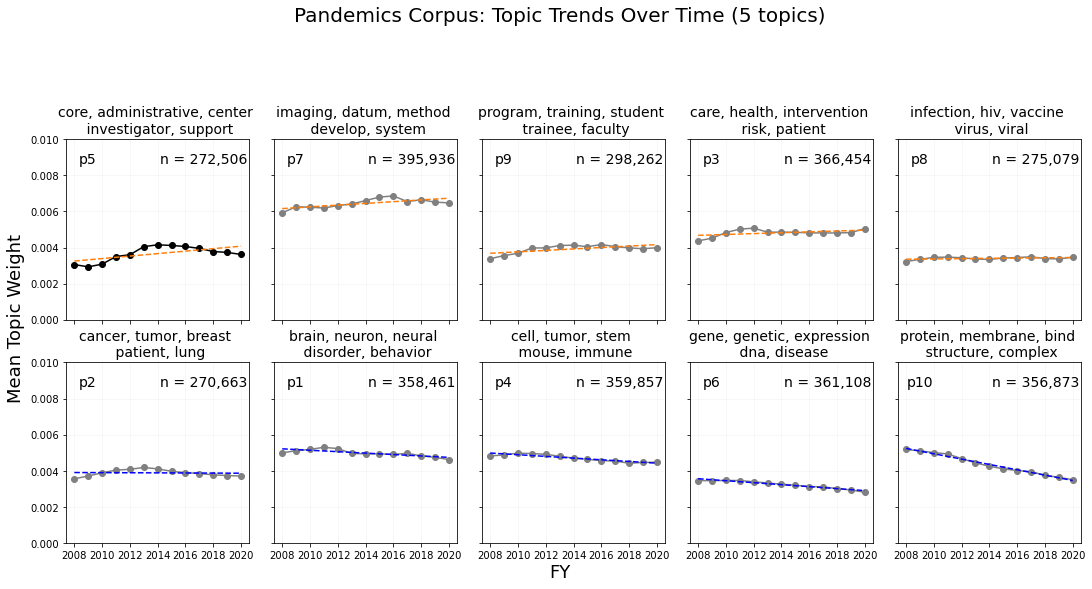

In [169]:
# set up grid
fig, ax = plt.subplots(2, 5, sharex = True, sharey = True, figsize=(15,8))
plt.ylim(bottom = 0.00, top = 0.01) 
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_filt.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    if(count in [0]): # upward trend in 2020, 20: [0,1,4,9,12]
        line_color = 'black'
    else: # downward trend in 2020
        line_color = 'gray'
    
    ax[i,j].errorbar(topic_wts_filt["FY"], topic_wts_filt[col], 
            yerr = np.array(topic_wts_se_filt[col]), fmt = '-o', color = line_color, zorder = 10) 
    
    ax[i,j].plot(topic_wts_filt["FY"], \
        (topic_wts_filt["FY"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 14)
    
    # add topic number to each plot
    ax[i,j].text(0.12, 0.89, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.75, 0.89, "n = " + f"{n_by_topic[col_idx]:,}", horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Pandemics Corpus: Topic Trends Over Time (5 topics)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.75)

#plt.savefig("./figures/pan_05topic_trends.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_05topic_trends.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

#### Dominant Topic Funding Calculation

In [100]:
doc_topic[0:10,:]

array([[0.00000000e+00, 1.17275933e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.52322002e-03, 1.72613283e-03, 1.83529271e-02,
        1.37116800e-03, 5.17427368e-04],
       [0.00000000e+00, 2.03073571e-03, 0.00000000e+00, 0.00000000e+00,
        2.54485329e-04, 1.55211748e-02, 8.90610728e-04, 3.42232867e-03,
        0.00000000e+00, 1.65630584e-03],
       [1.04345045e-03, 2.49206736e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.15511326e-04, 6.32045708e-03,
        0.00000000e+00, 0.00000000e+00],
       [1.76877976e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.19715532e-02, 2.42648575e-03, 0.00000000e+00, 1.45688864e-03,
        3.30082780e-04, 4.32645064e-03],
       [0.00000000e+00, 4.74483240e-03, 3.19857495e-05, 0.00000000e+00,
        0.00000000e+00, 1.87312442e-02, 0.00000000e+00, 1.43115310e-02,
        0.00000000e+00, 2.49420031e-03],
       [0.00000000e+00, 0.00000000e+00, 1.07425865e-03, 0.00000000e+00,
   

In [101]:
type(doc_topic)

numpy.ndarray

In [102]:
dom_top_df = df.copy()

In [103]:
dom_top_df['dom_top'] = np.argmax(doc_topic, axis=1)

In [104]:
dom_top_df['dom_top'][0:20]

0     7
1     5
2     7
3     0
4     5
5     5
6     9
7     5
8     5
9     5
10    7
11    7
12    7
13    5
14    5
15    7
16    7
17    5
18    9
19    7
Name: dom_top, dtype: int64

In [105]:
dom_top_df.head()

,Unnamed: 0,Unnamed: 0.1,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,dom_top
0,768,NaN,NaN,768,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,NaN,Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",1.0,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1.0,1.0,1999467.0,1.0,project explore game base metaphor enhanced ga...,7
1,771,NaN,NaN,771,89999,In partnership with the American Chemical Soci...,NaN,NaN,NaN,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",4.0,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1.0,1.0,51000.0,1.0,partnership american chemical society acs nati...,5
2,776,NaN,NaN,776,90006,MAPPING / CHARACTERIZATION / AND ANALYSIS OF C...,NaN,NaN,NaN,Data; Image; instrument; Maps; Radar; Titan,MAPPING / CHARACTERIZATION / AND ANALYSIS OF C...,NASA,NASA,NaN,NNX08BA81G,9/9/2008,9/8/2011,"BURR, DEVON",NaN,2.0,003387891,UNIVERSITY OF TENNESSEE KNOXVILLE,KNOXVILLE,TN,37996-0003,UNITED STATES,NaN,NaN,43.AAA,2008,197533.0,NaN,1.0,1.0,197533.0,1.0,mapping characterization analysis channel vall...,7
3,778,NaN,NaN,778,89993,Amphibian populations around the world are exp...,NaN,NaN,NaN,Amphibia; Central America; Communicable Diseas...,COLLABORATIVE RESEARCH: EVOLUTION OF AMPHIBIAN...,NSF,NSF,NaN,0815288,10/1/2008,3/31/2009,"LIPS, KAREN R",NaN,12.0,939007555,SOUTHERN ILLINOIS UNIVERSITY CARBONDALE,CARBONDALE,IL,62901-4709,UNITED STATES,NaN,NaN,47.074,2008,NaN,NaN,2.0,2.0,370996.0,2.0,amphibian population world experience decline ...,0
4,780,NaN,NaN,780,90011,The Ohio State University College of Education...,NaN,NaN,NaN,career; career development; Collaborations; Co...,MATH AND SCIENCE MIDDLE SCHOOL PATHWAYS PORTAL...,NSF,NSF,NaN,0840824,9/1/2008,8/31/2011,"LIGHTLE, KIMBERLY S","KAHLE, JANE; HENTON, MARY; NAIR-PILLAI, SARITA",15.0,071650709,OHIO STATE UNIVERSITY RESEARCH FOUNDATION,COLUMBUS,OH,43210-1016,UNITED STATES,NaN,NaN,47.076,2008,2369022.0,NaN,1.0,1.0,2369022.0,1.0,ohio state university college education osu na...,5


In [106]:
dollars_by_top_yr = dom_top_df.groupby(['dom_top', 'FY']).agg(COST = ('FY_TOTAL_COST_SUM', 'sum'),
                                        NUM_PROJECTS = ('PROJECT_ID', 'count'))
dollars_by_top_yr

COST  NUM_PROJECTS
dom_top FY                              
0       2008  1.232284e+09          3413
        2009  1.508639e+09          3524
        2010  1.450403e+09          3317
        2011  1.183566e+09          2896
        2012  1.144505e+09          2789
...                    ...           ...
9       2016  2.478438e+09          5153
        2017  2.532661e+09          5211
        2018  2.816471e+09          5714
        2019  3.006796e+09          5900
        2020  3.404905e+09          6549

[130 rows x 2 columns]

In [58]:
dollars_by_top_yr.index.get_level_values(0)

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='dom_top')

In [59]:
dollars_by_top_yr.loc[0,'2008']

KeyError: '2008'

In [61]:
year = dollars_by_top_yr.loc[0]['COST'].index.values.astype('int')
year

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

In [77]:
dollars_by_top_yr.loc[1]['COST'].values

array([2.49584900e+07, 4.84257350e+07, 4.43161280e+07, 8.42726020e+07,
       2.70007410e+07, 1.94718570e+07, 1.44426010e+07, 2.19935570e+07,
       2.18596360e+07, 2.25130660e+07, 2.91272290e+07, 2.87742200e+07,
       1.71029352e+09])

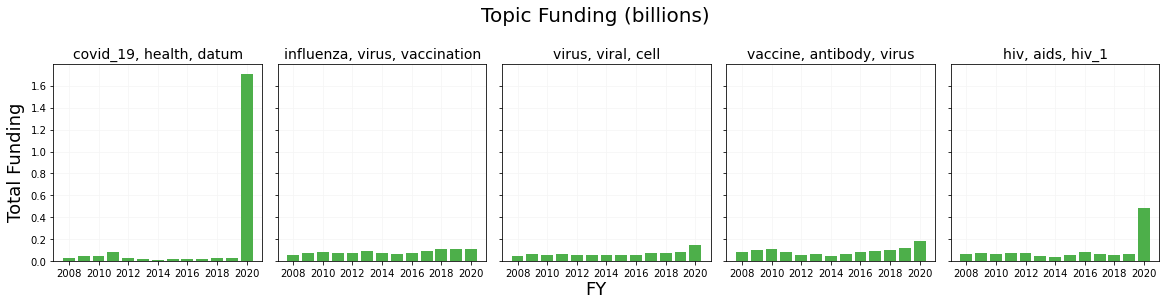

In [88]:
# set up grid
fig, ax = plt.subplots(1, 5, sharex = True, sharey = True, figsize=(16,4))
#plt.ylim(bottom = 0, top = 200) 
#plt.yscale('log')
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count, topic in enumerate([1,2,0,3,4]):
        
    # map count to i,j in grid
    #i = count // 5
    j = count % 5
    
    year = dollars_by_top_yr.loc[topic]['COST'].index.values.astype('int')
    cost = dollars_by_top_yr.loc[topic]['COST'].values/1000000000
    
    ax[j].bar(year, cost, color = cb_pal['green']) 
    ax[j].grid(color = "whitesmoke")   
    ax[j].set_title(new_leg[topic], fontsize = 14)
    ax[j].set_axisbelow(True)
    
    # add topic number to each plot
    #ax[j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    #ax[j].text(0.75, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    
fig.suptitle('Topic Funding (billions)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Total Funding', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.78)

#plt.savefig("./figures/pan_05topic_trends_alt.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_05topic_trends_alt.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

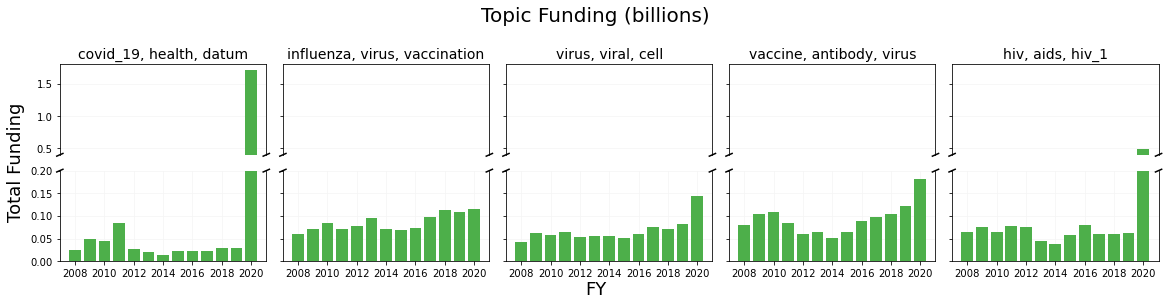

In [112]:
# set up grid
fig, ax = plt.subplots(2, 5, sharex = False, sharey = 'row', figsize=(16,4))
#plt.ylim(bottom = 0, top = 200) 
#plt.yscale('log')
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count, topic in enumerate([1,2,0,3,4]):
        
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    # plot data
    year = dollars_by_top_yr.loc[topic]['COST'].index.values.astype('int')
    cost = dollars_by_top_yr.loc[topic]['COST'].values/1000000000
    
    ax[i+1,j].bar(year, cost, color = cb_pal['green']) 
    ax[i+1,j].grid(color = "whitesmoke")   
    ax[i+1,j].set_axisbelow(True)
    
    ax[i,j].bar(year, cost, color = cb_pal['green']) 
    ax[i,j].grid(color = "whitesmoke")   
    ax[i,j].set_title(new_leg[topic], fontsize = 14)
    ax[i,j].set_axisbelow(True)
    
    # broken axis
    ax[i,j].spines['bottom'].set_visible(False)
    ax[i,j].set_xticks([])
    ax[i+1,j].set_xticks(np.arange(2008,2021,2))
    ax[i+1,j].spines['top'].set_visible(False)
    ax[i+1,j].set_ylim([0,0.2])
    ax[i,j].set_ylim([0.4,1.8])
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[i,j].transAxes, color='k', clip_on=False)
    ax[i,j].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax[i,j].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax[i+1,j].transAxes)  # switch to the bottom axes
    ax[i+1,j].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax[i+1,j].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    
    # add topic number to each plot
    #ax[j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    #ax[j].text(0.75, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    
fig.suptitle('Topic Funding (billions)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Total Funding', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.78)

plt.savefig("./figures/OECD/pan_05topic_funding.png", dpi = 800, bbox_inches = "tight")
plt.savefig("./figures/OECD/pan_05topic_funding.pdf", dpi = 800, bbox_inches = "tight")
plt.show()